# Fast R-CNN

To make R-CNN faster, Girshick (2015) improved the training procedure by unifying three independent models into one jointly trained framework and increasing shared computation results, named Fast R-CNN. Instead of extracting CNN feature vectors independently for each region proposal, this model aggregates them into one CNN forward pass over the entire image and the region proposals share this feature matrix. Then the same feature matrix is branched out to be used for learning the object classifier and the bounding-box regressor. In conclusion, computation sharing speeds up R-CNN.

In [2]:
import os 
import glob
import pandas as pd
from collections import Counter 
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split


import torch

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

from torchsummary import summary


from torchvision import models
from torchvision import transforms as T

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as patches

from dataload import xml_to_csv,PetData,Sub_region_train,Sub_region

from tqdm import tqdm
from utills import ssearch,misc
from utills.misc import create_label,balance_df
from metrics import iou

import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

In [3]:
##Loading data
#root_path="D:/Dataset/Pet_Data/"
root_path="D:/Dataset/Oxford"

img_path=os.path.join(root_path,"images")
annotation_path=os.path.join(root_path,"annotations/xmls")           
annots = glob.glob(annotation_path+"/*.xml")
seed=0
df=xml_to_csv(annots,img_path)
df.head()

## Make Balanced Dataset (To save time, but don't do this in real research!!)
g = df.groupby('target')
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min(),random_state=seed).reset_index(drop=True),))  
## 
train, valid = train_test_split(balanced_df, test_size=0.3,random_state=seed)  

BATCH_SIZE = 1




## Updated Dataset Class (Added Selective Search "inside" original class)

In [169]:
class PetData(Dataset):
    def __init__(self, dataframe,train=False,ssearch=False,samples=16):
        self.df=dataframe
        self.ssearch=ssearch
        self.transform=iaa.Sequential([iaa.Resize((224,224))])
        self.torch_transform=T.Compose([T.ToTensor(),
                                        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])    
        self.samples=samples
        self.train=train
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        regions=None
        fn,target,xmin,ymin,xmax,ymax=self.df.iloc[idx] #
        im=cv2.cvtColor(cv2.imread(fn),cv2.COLOR_BGR2RGB) ##Load Img
        
        class_label=target+1  ##Class #0 represents background
        bbs=BoundingBoxesOnImage([BoundingBox(xmin,ymin,xmax,ymax,label=class_label)], shape=im.shape) #BBox
        image_aug, bbs_aug = self.transform(image=im, bounding_boxes=bbs) #Transformation
        bbs_aug=torch.stack([torch.tensor([bb.x1,bb.y1,bb.x2,bb.y2,bb.label]) for bb in bbs_aug])
        
        region_np=[]
        img_shape=image_aug.shape   
        
        if self.ssearch:                                
            regions=ssearch.selective_search(image_aug, scale=50, sigma=0.8, min_size=20)
            if self.train:
                regions=create_label(regions,bbs_aug,iou_threshold=0.5)
                regions=[dict(t) for t in {tuple(d.items()) for d in regions}]
                for dicts in regions:
                    region_np.append((np.array(dicts['rect'],dtype=np.float)))
                region_np=np.stack(region_np)
                region_np=region_np[np.where(region_np[:,-1]>0.1)]
                
                try:
                    pos_idx = random.choices(np.where((region_np[:,4]) != 0)[0],k=16)
                except:
                    pos_idx=[]
                neg_samples=64
                if len(pos_idx):
                    neg_samples=48
                neg_idx = random.choices(np.where((region_np[:,4]) == 0)[0],k=neg_samples)
                region_np=region_np[pos_idx+neg_idx]
                region_np=torch.from_numpy(region_np)
                labels=region_np[:,4].long()
                bbox_idx=region_np[:,5].long()
                region_np=torch.stack([torch.clamp(region_np[:,0]-16,0,img_shape[1]),
                                       torch.clamp(region_np[:,1]-16,0,img_shape[0]),
                                       torch.clamp(region_np[:,2]+16,0,img_shape[1]),
                                       torch.clamp(region_np[:,3]+16,0,img_shape[0])],dim=1)  
            else:
                regions=[dict(t) for t in {tuple(d.items()) for d in regions}]
                for dicts in regions:
                    region_np.append((np.array(dicts['rect'],dtype=np.float)))
                region_np=np.stack(region_np)
                        
                region_np=torch.from_numpy(region_np)
                region_np=torch.stack([torch.clamp(region_np[:,0]-16,0,img_shape[1]),
                                       torch.clamp(region_np[:,1]-16,0,img_shape[0]),
                                       torch.clamp(region_np[:,2]+16,0,img_shape[1]),
                                       torch.clamp(region_np[:,3]+16,0,img_shape[0])],dim=1)
                return self.torch_transform(image_aug), bbs_aug,region_np,

        return self.torch_transform(image_aug), bbs_aug,region_np#,labels,bbox_idx

In [170]:
train_ds = PetData(train, train=True, ssearch=True)
valid_ds= PetData(valid, train=True,ssearch=True)

BATCH_SIZE=2
def collate_fn(batch):
    return zip(*batch)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn,shuffle=False)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=BATCH_SIZE
                                       , collate_fn=collate_fn)

In [171]:
train_ds[0][2].shape

(488, 7)

In [172]:
root_path="D:/Dataset/OD_Data/train"
file_name=["img.pt",
"bbs.pt",
"region_np.pt",
"labels.pt",
"bbox_idx.pt"]
for idx,dataset in enumerate(tqdm(train_ds)):
    save_path=os.path.join(root_path,f'{idx:05}')
    try:
        os.mkdir(save_path)
    except:
        print("folder exists")
        idx=141
    for index,data in enumerate(dataset):
        torch.save(data,os.path.join(save_path,file_name[index]))

100%|██████████████████████████████████████████████████████████████████████████████| 1663/1663 [37:52<00:00,  1.37s/it]


In [173]:
root_path="D:/Dataset/OD_Data/valid"

for idx,dataset in enumerate(tqdm(valid_ds)):
    save_path=os.path.join(root_path,f'{idx:05}')
    try:
        os.mkdir(save_path)
    except:
        print("folder exists")
        idx=141
    for index,data in enumerate(dataset):
        torch.save(data,os.path.join(save_path,file_name[index]))

100%|████████████████████████████████████████████████████████████████████████████████| 713/713 [16:17<00:00,  1.37s/it]


In [132]:
train_path=glob.glob("D:/Dataset/OD_Data/train/*")
train_ds=Custom_PetData(train_path,train=True)

## <center>    First, pre-train a convolutional neural network on image classification tasks. </center>


In [10]:
model = models.vgg16(pretrained=True)
def count_parameters(model):ZZ
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
                              
print(f'Num of parameters: {count_parameters(model)}')


Num of parameters: 138357544


## Fast RCNN Network Architecture


![ROI](https://i.imgur.com/yYIDM5h.png)

In [11]:
class roi_pooling(nn.Module):
    def __init__(self,ft_shape,img_shape,size):
        '''
        '''
        super(roi_pooling, self).__init__()
        self.size=size
        #Layers
        self.img_shape=img_shape
        self.ft_shape=ft_shape
        self.adaptivepool=nn.AdaptiveMaxPool2d(size[0], size[1])
    
    def forward(self,ft,rois):
        batch_size=len(rois)
        out=[]
        for i in range(batch_size):
            out_img=[]
            roi=rois[i]
            ft_img=ft[i].unsqueeze(0)

            x1=torch.floor((roi[:,0]/self.img_shape)*self.ft_shape).type(torch.int32)
            y1=torch.floor((roi[:,1]/self.img_shape)*self.ft_shape).type(torch.int32)
            x2=torch.ceil((roi[:,2]/self.img_shape)*self.ft_shape).type(torch.int32)
            y2=torch.ceil((roi[:,3]/self.img_shape)*self.ft_shape).type(torch.int32)

            for j in range(roi.shape[0]):
                ft_img_=ft_img[:,:,y1[j]:y2[j], x1[j]:x2[j]]
                ft_img_ = self.adaptivepool(ft_img_)[0]
                out_img.append(ft_img_)
            out_img=torch.cat(out_img, dim=0).unsqueeze(0)  
            out.append(out_img)
        out = torch.cat(out, dim=0)  
        return out
    

In [12]:
class Fast_RCNN(nn.Module):
    def __init__(self,ft_shape=32,img_shape=224,num_class=2):
        '''
        '''
        super(Fast_RCNN, self).__init__()
        
        self.num_class=num_class
        
        #Layers
       # self.pretrained=models.vgg16(pretrained=True)
        self.ft_net=models.vgg16(pretrained=True).features[0:-1]
        self.roi=roi_pooling(ft_shape=14,img_shape=img_shape,size=(7,7))
        self.classifier_net=models.vgg16(pretrained=True).classifier[0:-1]
        self.cls_score = nn.Linear(4096, num_class+1)
        self.bbox = nn.Linear(4096, 4*(num_class+1))
                

    def forward(self,imgs,regions):
        
        fts=self.ft_net(imgs)
        o_roi=self.roi(fts,regions)
        
        batch_size=o_roi.shape[0]
        regions_num=o_roi.shape[1]
        
        o_roi=o_roi.detach()
        o_roi=o_roi.view(batch_size*regions_num,-1)
        ft=self.classifier_net(o_roi)
        
        cls_score = self.cls_score(ft).view(batch_size*regions_num,-1)
        bbox = self.bbox(ft).view(batch_size*regions_num, self.num_class+1, 4)
        
      #  cls_score = self.cls_score(ft).view(batch_size,regions_num,-1)
       # bbox = self.bbox(ft).view(batch_size,regions_num, self.num_class+1, 4)
        return cls_score,bbox
    

In [13]:
fastRCNN=Fast_RCNN()
fastRCNN
fastRCNN.eval()

fastRCNN.load_state_dict(torch.load("E:/OD_models/FAST_RCNN/epoch_47.pth"))

<All keys matched successfully>

In [14]:
## Single Batch Test

In [15]:
single_batch=next(iter(train_dl))

In [16]:
img,gt_box,rois,label,bbox_idx=single_batch

img=torch.stack([i for i in img])
gt_box=torch.stack([i for i in gt_box])
rois=torch.stack([i for i in rois])
rois_label=torch.stack([i for i in label]).reshape(-1)
bbox_idx=torch.stack([i for i in bbox_idx])

In [17]:
#Forward

In [18]:
clf_score,offsets=fastRCNN(img,rois)

![image.png](https://i.imgur.com/oEktP0k.png)


![image.png](https://i.imgur.com/v9D5lTU.png)

![image.png](https://i.imgur.com/I7kpSxV.png)


In [19]:
from utills.misc import cvtScale

In [23]:
clf_crit=nn.CrossEntropyLoss()
clf_loss=clf_crit(clf_score,rois_label)
clf_loss

tensor(0.0008, grad_fn=<NllLossBackward>)

In [21]:
rois=rois.reshape(-1,4)
tgt_box=[]

lbl = rois_label.view(-1, 1, 1).expand(rois_label.size(0), 1, 4)
mask = (rois_label != 0).float().view(-1, 1).expand(rois_label.size(0), 4)


for img_idx,bbox_idx_image in enumerate(bbox_idx):
    tgt_box.append(torch.stack([cvtScale(gt_box[img_idx][bbox_idx])  for bbox_idx in bbox_idx_image]))
tgt_box=torch.cat(tgt_box,dim=0).detach()

t_x=(tgt_box[:,0]-rois[:,0])/rois[:,2]
t_y=(tgt_box[:,1]-rois[:,1])/rois[:,3]
t_w=torch.log(tgt_box[:,2]/rois[:,2])
t_h=torch.log(tgt_box[:,3]/rois[:,3])

tgt_offset=torch.stack([t_x,t_y,t_w,t_h],dim=1)
tgt_offset=tgt_offset*mask.detach()

offsets=offsets.gather(1, lbl).squeeze(1)* mask                                                

In [22]:
reg_crit=nn.SmoothL1Loss()
reg_loss=reg_crit(offsets,tgt_offset.float())
reg_loss

tensor(0.0009, grad_fn=<SmoothL1LossBackward>)

In [18]:
optimizer = torch.optim.Adam(fastRCNN.parameters(), lr=1e-4)

In [19]:
from utills.tboard import Writer,delete_files

In [20]:
# base_folder="experiments"
# try:
#     os.mkdir(base_folder)
# except:
#     print("Exists")
#Create TensorBoard Summary
#
writer=Writer("FastRCNN","experiments")

Event are saved under experiments\FastRCNN\7


## Training

In [22]:
'''
epochs=100
device="cuda"
fastRCNN.to(device)
reg_crit=nn.L1Loss()
clf_crit=nn.CrossEntropyLoss()

train_log_idx=0
valid_log_idx=0
for epoch in range(50,epochs):
    print(f"epochs: {epoch}")

    
    fastRCNN.train()
    fastRCNN.to(device)
    correct=0
    total=0
    for batch_idx,(img,gt_box,rois,label,bbox_idx) in enumerate(train_dl):
        optimizer.zero_grad()
        

        img=torch.stack([i for i in img])
        gt_box=torch.stack([i for i in gt_box])
        rois=torch.stack([i for i in rois])
        rois_label=torch.stack([i for i in label]).reshape(-1)
        bbox_idx=torch.stack([i for i in bbox_idx])
        
        img=img.to(device)
        rois=rois.to(device)     
        
        clf_score,offsets=fastRCNN(img,rois)
        rois=rois.to("cpu")
        
                
        rois=rois.reshape(-1,4)
        tgt_box=[]

        lbl = rois_label.view(-1, 1, 1).expand(rois_label.size(0), 1, 4)
        mask = (rois_label != 0).float().view(-1, 1).expand(rois_label.size(0), 4)
        for img_idx,bbox_idx_image in enumerate(bbox_idx):
            tgt_box.append(torch.stack([cvtScale(gt_box[img_idx][bbox_idx])  for bbox_idx in bbox_idx_image]))
        tgt_box=torch.cat(tgt_box,dim=0).detach()
        t_x=(tgt_box[:,0]-rois[:,0])/rois[:,2]
        t_y=(tgt_box[:,1]-rois[:,1])/rois[:,3]
        t_w=torch.log(tgt_box[:,2]/rois[:,2])
        t_h=torch.log(tgt_box[:,3]/rois[:,3])
        tgt_offset=torch.stack([t_x,t_y,t_w,t_h],dim=1)
        tgt_offset=tgt_offset*mask.detach()

        tgt_offset=tgt_offset.to(device)
        lbl=lbl.to(device)
        mask=mask.to(device)
        offsets=offsets.gather(1, lbl).squeeze(1)* mask                                                                               
        
        rois_label=rois_label.to(device)
        tgt_offset=tgt_offset.to(device)
        clf_loss=clf_crit(clf_score,rois_label)
        
        
        reg_loss=reg_crit(offsets,tgt_offset)
        
        _, predicted = torch.max(clf_score.data, 1)
        total+=rois_label.size()[0]
        correct += (predicted == rois_label).sum().item()
        
        
        total_loss=clf_loss+reg_loss
        total_loss.backward()
        optimizer.step()
        
        if batch_idx % 50==0:
            print(f'batch_idx: {batch_idx}/{len(train_dl)}')
            print(f'CLFLOSS: {clf_loss.item()}')
            print(f'REGLOSS: {reg_loss.item()}')
            print(f'ACCURACY: {correct/(total)}')
            writer.add_events("clf_loss",clf_loss.item(),train_log_idx)
            writer.add_events("reg_loss",reg_loss.item(),train_log_idx)
            writer.add_events("Accuracy",correct/(total),train_log_idx)
            train_log_idx+=1
    torch.save(fastRCNN.state_dict(), "E:/OD_models/FAST_RCNN/"+f"epoch_{epoch}.pth")


    '''
print("")

## Eval

In [25]:
single_valid=train_ds[2]

In [26]:
#fastRCNN=Fast_RCNN()

#fastRCNN.load_state_dict(torch.load("pretrained_model/FastRCNN_42.pth"))
fastRCNN.eval()
fastRCNN.to("cpu")
print("Model_loaded")

Model_loaded


In [29]:
img,gt_bbox,proposed_regions,_,_=single_valid

### Input Img +GT

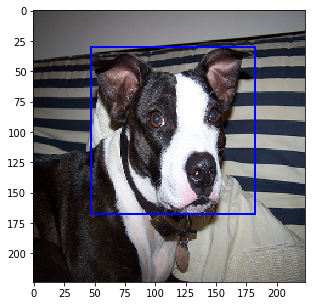

torch.Size([3, 224, 224])

In [30]:
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(T.ToPILImage()(img*0.5+0.5))
for bbox in gt_bbox:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False,
         linewidth=2) )
plt.show()
single_valid[0].shape

In [47]:
chunks=torch.split(proposed_regions, 64)
dets=[]
confs=[]
offsets=[]
with torch.no_grad():
    for x in chunks:
        clf_score,offset=fastRCNN(img.unsqueeze(0),x.unsqueeze(0))
        clf_score=nn.Softmax(dim=1)(clf_score)
        idx=torch.max(clf_score,1).indices.nonzero()
        if len(idx) != 0 :
            dets.append(x[idx])
            offsets.append(offset[idx])
            confs.append(clf_score[idx])

dets=torch.cat(dets,dim=0)
dets=dets.squeeze(1)

offsets=torch.cat(offsets,dim=0)
offsets=offsets.squeeze(1)

confs=torch.cat(confs,dim=0)
confs=confs.squeeze(1)


### Before Regression+NMS

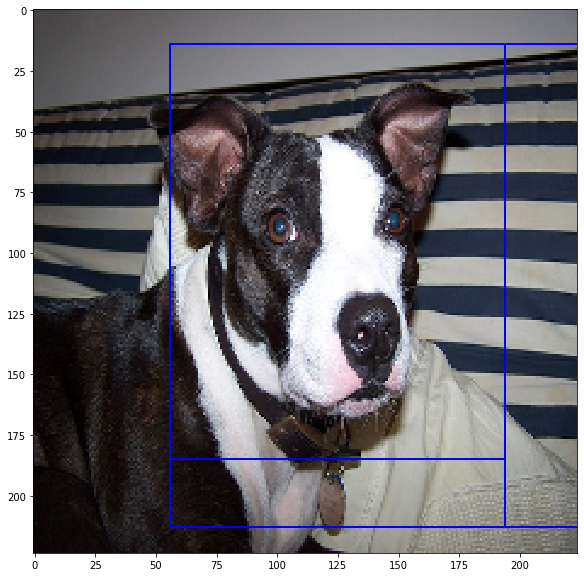

torch.Size([3, 224, 224])

In [51]:
fig, ax = plt.subplots(figsize=(10,10))

ax.imshow(T.ToPILImage()(img*0.5+0.5))
for bbox in dets:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False,
         linewidth=2) )
plt.show()
single_valid[0].shape

![img](https://i.imgur.com/0I6dcDS.png)

In [76]:
score,labels=torch.max(confs,1)

offset_list=[]
for (label,offset) in zip(labels,offsets):
    offset_list.append(offset[label])
offset_list=torch.stack(offset_list)
cvtdets=torch.stack([cvtScale(x) for x in dets])

In [34]:
def cvtScale_xxyy(box): #Convert  xc,yc,wid,hei to x1,y1,x2,y2, 
    hw=box[2]/2.0
    hh=box[3]/2.0
    return torch.tensor([box[0]-hw,box[1]-hh,box[0]+hw,box[1]+hh])

In [79]:
xc=cvtdets[:,2]*offset_list[:,0]+cvtdets[:,0]
yc=cvtdets[:,3]*offset_list[:,1]+cvtdets[:,1]
width=cvtdets[:,2]*torch.exp(offset_list[:,2])
height=cvtdets[:,3]*torch.exp(offset_list[:,2])
cvtdets=torch.stack([xc,yc,width,height],dim=1)
new_cvtdets=torch.stack([cvtScale_xxyy(x) for x in cvtdets])

In [73]:
new_cvtdets

tensor([[125.0650, 113.7904, 215.6757, 226.0689],
        [138.5391, 123.7214, 246.7093, 251.8516],
        [138.5391, 123.7214, 246.7093, 251.8516],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [125.0650, 113.7904, 215.6757, 226.0689],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [125.0650, 113.7904, 215.6757, 226.0689],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [125.0650, 113.7904, 215.6757, 226.0689],
        [125.0650, 113.7904, 215.6757, 226.0689],
        [125.0650, 113.7904, 215.6757, 226.0689],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [121.8292, 124.5919, 211.4147, 253.7767],
        [121.8292, 124.5919, 211.4147, 253.7767]], dtype=torch.float64)

In [37]:
offset_list

tensor([[ 0.3288,  0.4119, -0.4207, -0.2827],
        [ 0.3132,  0.3733, -0.4403, -0.3520],
        [ 0.3132,  0.3733, -0.4403, -0.3520],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3288,  0.4119, -0.4207, -0.2827],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3288,  0.4119, -0.4207, -0.2827],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3288,  0.4119, -0.4207, -0.2827],
        [ 0.3288,  0.4119, -0.4207, -0.2827],
        [ 0.3288,  0.4119, -0.4207, -0.2827],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3016,  0.3803, -0.4321, -0.3613],
        [ 0.3016,  0.3803, -0.4321, -0.3613]])

In [46]:
dets

tensor([[ 56.,  14., 194., 185.],
        [ 56.,  14., 224., 213.],
        [ 56.,  14., 224., 213.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 185.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 185.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 185.],
        [ 56.,  14., 194., 185.],
        [ 56.,  14., 194., 185.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 213.],
        [ 56.,  14., 194., 213.]], dtype=torch.float64)

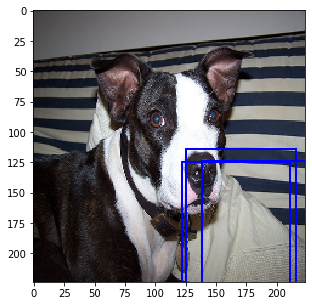

torch.Size([3, 224, 224])

In [39]:
fig, ax = plt.subplots(figsize=(5,5))

ax.imshow(T.ToPILImage()(img*0.5+0.5))
for bbox in new_cvtdets:
    xy=(bbox[0],bbox[1])
    width=bbox[2]-bbox[0]
    height=bbox[3]-bbox[1]
    ax.add_patch(
     patches.Rectangle(
        xy,
        width,
        height,
        edgecolor = 'blue',
        fill=False,
         linewidth=2) )
plt.show()
single_valid[0].shape

In [40]:
def reg_to_bbox(img_size, reg, box):
    img_width, img_height = img_size
    bbox_width = box[:,2] - box[:,0] + 1.0
    bbox_height = box[:,3] - box[:,1] + 1.0
    bbox_ctr_x = box[:,0] + 0.5 * bbox_width
    bbox_ctr_y = box[:,1] + 0.5 * bbox_height

    bbox_width = bbox_width[:,np.newaxis]
    bbox_height = bbox_height[:,np.newaxis]
    bbox_ctr_x = bbox_ctr_x[:,np.newaxis]
    bbox_ctr_y = bbox_ctr_y[:,np.newaxis]

    out_ctr_x = reg[:,:,0] * bbox_width + bbox_ctr_x
    out_ctr_y = reg[:,:,1] * bbox_height + bbox_ctr_y

    out_width = bbox_width * np.exp(reg[:,:,2])
    out_height = bbox_height * np.exp(reg[:,:,3])
    print(img_height)
    return np.array([
        np.maximum(0, out_ctr_x - 0.5 * out_width),
        np.maximum(0, out_ctr_y - 0.5 * out_height),
        np.minimum(img_width, out_ctr_x + 0.5 * out_width),
        np.minimum(img_height, out_ctr_y + 0.5 * out_height)
    ])

In [93]:
reg_to_bbox((224,224),offset_list[0].unsqueeze(0).unsqueeze(0),dets[0].unsqueeze(0))

224


array([116.4361659 , 108.64040685, 192.94628266, 213.84240001])

In [65]:
gt_bbox

tensor([[ 47.0400,  29.8667, 181.8880, 167.8507,   2.0000]])

In [42]:
co=nn.SmoothL1Loss()

In [43]:
co(offset_list,tgt_offset)

C:\Users\admin\anaconda3\lib\site-packages\torch\nn\modules\loss.py:798: UserWarning: Using a target size (torch.Size([128, 4])) that is different to the input size (torch.Size([16, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (16) must match the size of tensor b (128) at non-singleton dimension 0

In [41]:
co(tgt_offset,offset_list)

NameError: name 'co' is not defined

In [68]:
co(offset_list[0][0],tgt_offset[0][0])

tensor(0.0054, dtype=torch.float64)

In [69]:
0.10**2

0.010000000000000002